## Data Load and Exploration

In [1]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("data/dataset.csv", encoding="utf-8")

dataset.head()

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive


Final Status
Positive     215
Negative     184
Positive       1
Name: count, dtype: int64
Final Status
Positive     0.5375
Negative     0.4600
Positive     0.0025
Name: proportion, dtype: float64


<Axes: xlabel='Final Status'>

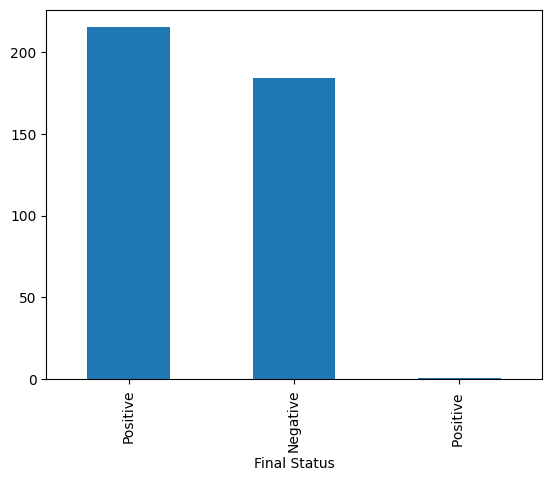

In [2]:
print(dataset["Final Status"].value_counts())

print(dataset["Final Status"].value_counts(normalize=True))

dataset["Final Status"].value_counts().plot(kind="bar")

## Data Cleaning

On line 97 of the original dataset CSV file, a space was found after the class label, originating in a new erroneous class.

In [3]:
dataset.iloc[97]["Final Status"]

'Positive '

In [4]:
dataset.iloc[97]["Final Status"] = 'Positive'
dataset.iloc[97]["Final Status"]

/var/folders/7h/1vqhnhpx2gl_zc8_6pj32nz80000gn/T/ipykernel_31082/987383253.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset.iloc[97]["Final Status"] = 'Positive'


'Positive'

Final Status
Positive    216
Negative    184
Name: count, dtype: int64
Final Status
Positive    0.54
Negative    0.46
Name: proportion, dtype: float64


<Axes: xlabel='Final Status'>

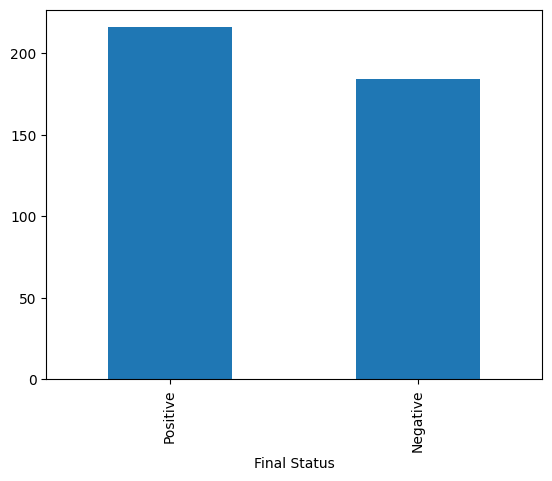

In [5]:
print(dataset["Final Status"].value_counts())

print(dataset["Final Status"].value_counts(normalize=True))

dataset["Final Status"].value_counts().plot(kind="bar")

In [6]:
# Convert to binary
dataset["Final Status"] = dataset["Final Status"].map({"Positive": 1, "Negative": 0})

In [7]:
print("Missing Values:\n", dataset.isnull().sum())

Missing Values:
 Date_published    0
Headline          0
Synopsis          1
Full_text         0
Final Status      0
dtype: int64


Since it's just an empty Synopsis, and we still have the title and full text, then we can leave it in the corpus. (However, we need to converter NaN field to empty string, otherwise the whole article would be ignored on the preprocessing phase.)

In [8]:
# Check  and clean empty Synopsis
dataset[dataset["Synopsis"].isna()].index

Index([56], dtype='int64')

In [9]:
dataset.loc[56, "Synopsis"] = " "

## Preprocessing Text

In [10]:
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

In [11]:
#replace contractions
def decontracted(phrase):
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
def preprocess_text(text):
    text = decontracted(text)
    text = re.sub("[^a-zA-Z]", " ", str(text))  # alpha only
    # text = re.sub("[^a-zA-Z0-9]", " ", str(text))  # also numbers
    # text = re.sub("[^a-zA-Z0-9%]", " ", str(text))  # also numbers and %
    tokens = word_tokenize(text.lower())
    # tokens = [token for token in tokens if token not in stop_words]
    tokens = [ps.stem(token) for token in tokens]
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

In [13]:
corpus = []
dataset["processed_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

# for future use in Lexicons
dataset["full_article"] = (
    dataset["Headline"] + " " + dataset["Synopsis"] + " " + dataset["Full_text"]
)

for i in range(len(dataset["processed_article"])):
    dataset.loc[i,"processed_article"] = preprocess_text(dataset["processed_article"][i])
    corpus.append(dataset["processed_article"][i])

In [14]:
corpus[:10]

['bank hold on to subsidi share say payment firm the compani have written to the nation payment corp of india npci complain that crore of the crore grant in the budget is be retain by bank reuterspay compani and bank are at loggerhead over the share of govern grant subsidi for build payment infrastructur said three peopl with knowledg of the matter the compani have written to the nation payment corp of india npci complain that crore of the crore grant in the budget is be retain by bank they said thi ha depriv compani connect up the last mile of state promis revenu accord to them the govern grant the subsidi in exchang for waiv merchant discount rate mdr charg the govern ha releas crore worth of subsidi to bank but they are not share it with ani payment aggreg said the ceo of a payment compani on condit of anonym compens for mdr waiver we have taken up the matter with npci which is the nodal agenc but the feedback that we got is that we should take the matter up with respect bank but th

In [15]:
vocab = set()

for s in corpus:
    vocab.update(s.split())

vocab_size = len(vocab)
print(vocab_size,list(vocab)[:20])

6506 ['keenli', 'embrac', 'exactli', 'contractionari', 'grown', 'goyalth', 'segment', 'agenciesrepres', 'baird', 'sooner', 'learnt', 'calcul', 'gujarat', 'argentina', 'attend', 'club', 'behavior', 'karan', 'otr', 'twice']


#### Wordclouds

A visually appealing way of observing words in a corpus is by showing wordclouds. In order to make a single wordcloud for the whole corpus, we can join all reviews together. We then pass it to [WordCloud](https://amueller.github.io/word_cloud/) to generate a wordcloud: it will automatically assign weights to words based on the number of occurrences of each word.

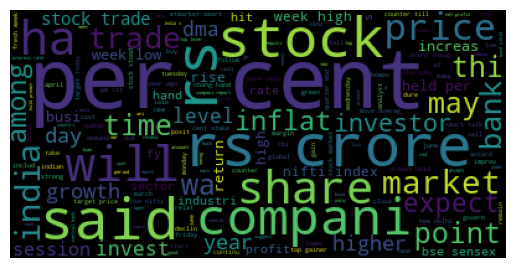

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

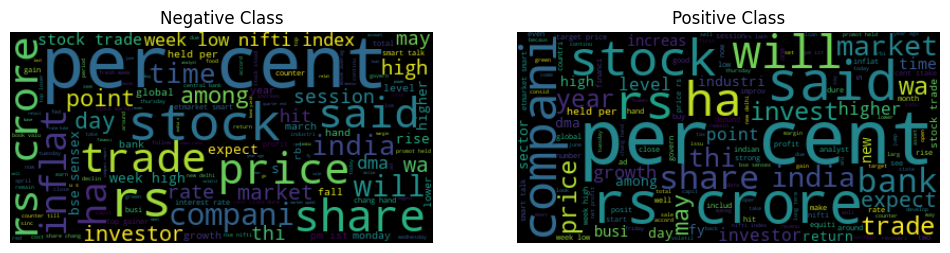

In [17]:
corpus_0 = []
corpus_1 = []

for i in range(0, dataset["processed_article"].size):
    article = dataset["processed_article"][i]
    label = dataset["Final Status"][i]
    if label == 0:
        corpus_0.append(article)
    else:
        corpus_1.append(article)

wordcloud_0 = WordCloud().generate(" ".join(corpus_0))
wordcloud_1 = WordCloud().generate(" ".join(corpus_1))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wordcloud_0, interpolation="bilinear")
axes[0].set_title("Negative Class")
axes[0].axis("off")
axes[1].imshow(wordcloud_1, interpolation="bilinear")
axes[1].set_title("Positive Class")
axes[1].axis("off")
plt.show()

## Vector Representation

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorizer = CountVectorizer()
#vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus).toarray()

print(X.shape)

(400, 58851)


In [19]:
print(vectorizer.get_feature_names_out()[:20])

['aa' 'aa plu' 'aadhaar' 'aadhaar link' 'aae' 'aae indian' 'aayog'
 'aayog had' 'aayog which' 'ab' 'ab inbev' 'aban' 'aban offshor' 'abat'
 'abat that' 'abbott' 'abbott india' 'abdulaziz' 'abdulaziz al' 'abdullah']


In [20]:
y = dataset['Final Status']

print(X.shape, y.shape)

(400, 58851) (400,)


## Train-Test Split

In [21]:
from sklearn.model_selection import (
    train_test_split,
    ParameterGrid,
    GridSearchCV,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("\nLabel distribution in the training set:")
print(y_train.value_counts())

print("\nLabel distribution in the test set:")
print(y_test.value_counts())

(320, 58851) (320,)
(80, 58851) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


## Modeling (and Tuning) Classifiers

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [23]:
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "Multi-Layer Perceptron": MLPClassifier(),
    "XGBoost": XGBClassifier(),
}

In [24]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

## Hyperparameter Tuning

In [25]:
param_grids = {
    "Logistic Regression": {  # TODO: check this one - some combinations are incompatible
        "solver": ["liblinear", "saga", "lbfgs"],
        "penalty": ["l1", "l2", "elasticnet", "none"],
        "C": [0.1, 1.0, 10.0],
        "max_iter": [1000],
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
    },
    "SVC": {
        "C": [0.1, 1.0, 10.0],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    # TODO: check the next ones - they don't easily converge
    "Multi-Layer Perceptron": {
        "hidden_layer_sizes": [(100,), (50, 50), (25, 25, 25)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "alpha": [0.001, 0.01],
        "max_iter": [500],
        "early_stopping": [True],
        "n_iter_no_change": [10],
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 6, 9],
        "n_estimators": [100, 200],
        "subsample": [0.8, 1.0],
    },
}

In [26]:
def tune_classifiers(classifiers, param_grid, X_train, y_train, X_test, y_test):
    best_params = {}

    for classifier_name, classifier in classifiers.items():
        if classifier_name in param_grids:
            param_grid = param_grids[classifier_name]

            if param_grid:
                print("_" * 40, f"\nTuning {classifier_name} model.\n\n")
                grid_search = GridSearchCV(
                    classifier, param_grid, cv=5, scoring="accuracy", n_jobs=-1
                )
                grid_search.fit(X_train, y_train)

                y_pred = grid_search.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)

                print("Classifier Accuracy:", accuracy)
                print("Best Parameters:", grid_search.best_params_)
                best_params[classifier_name] = grid_search.best_params_
    return best_params

In [27]:
best_params_so_far = {
    "Logistic Regression": {
        "C": 10.0,
        "max_iter": 1000,
        "penalty": "l1",
        "solver": "liblinear",
    },
    "Decision Tree": {
        "criterion": "entropy",
        "max_depth": 20,
        "min_samples_leaf": 4,
        "min_samples_split": 2,
    },
    "Random Forest": {
        "max_depth": None,
        "min_samples_leaf": 2,
        "min_samples_split": 5,
        "n_estimators": 300,
    },
    "SVC": {"C": 10.0, "gamma": "scale", "kernel": "sigmoid"},
    "Multi-Layer Perceptron": {
        "activation": "identity",
        "alpha": 0.01,
        "early_stopping": True,
        "hidden_layer_sizes": (25, 25, 25),
        "max_iter": 500,
        "n_iter_no_change": 10,
    },
    "XGBoost": {
        "learning_rate": 0.01,
        "max_depth": 6,
        "n_estimators": 200,
        "subsample": 0.8,
    },
}

In [28]:
# uncomment if changing parameters grids (re-tune all classifier models)
# best_params = tune_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test)
best_params = best_params_so_far

## Evaluation

In [29]:
classifiers_tuned = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(**best_params["Logistic Regression"]),
    "Decision Tree": DecisionTreeClassifier(**best_params["Decision Tree"]),
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "SVC": SVC(**best_params["SVC"]),
    "Multi-Layer Perceptron": MLPClassifier(**best_params["Multi-Layer Perceptron"]),
    "XGBoost": XGBClassifier(**best_params["XGBoost"]),
}

In [30]:
evaluations = {
    classifier_name: evaluate_classifier(classifier, X_train, y_train, X_test, y_test)
    for classifier_name, classifier in classifiers_tuned.items()
}

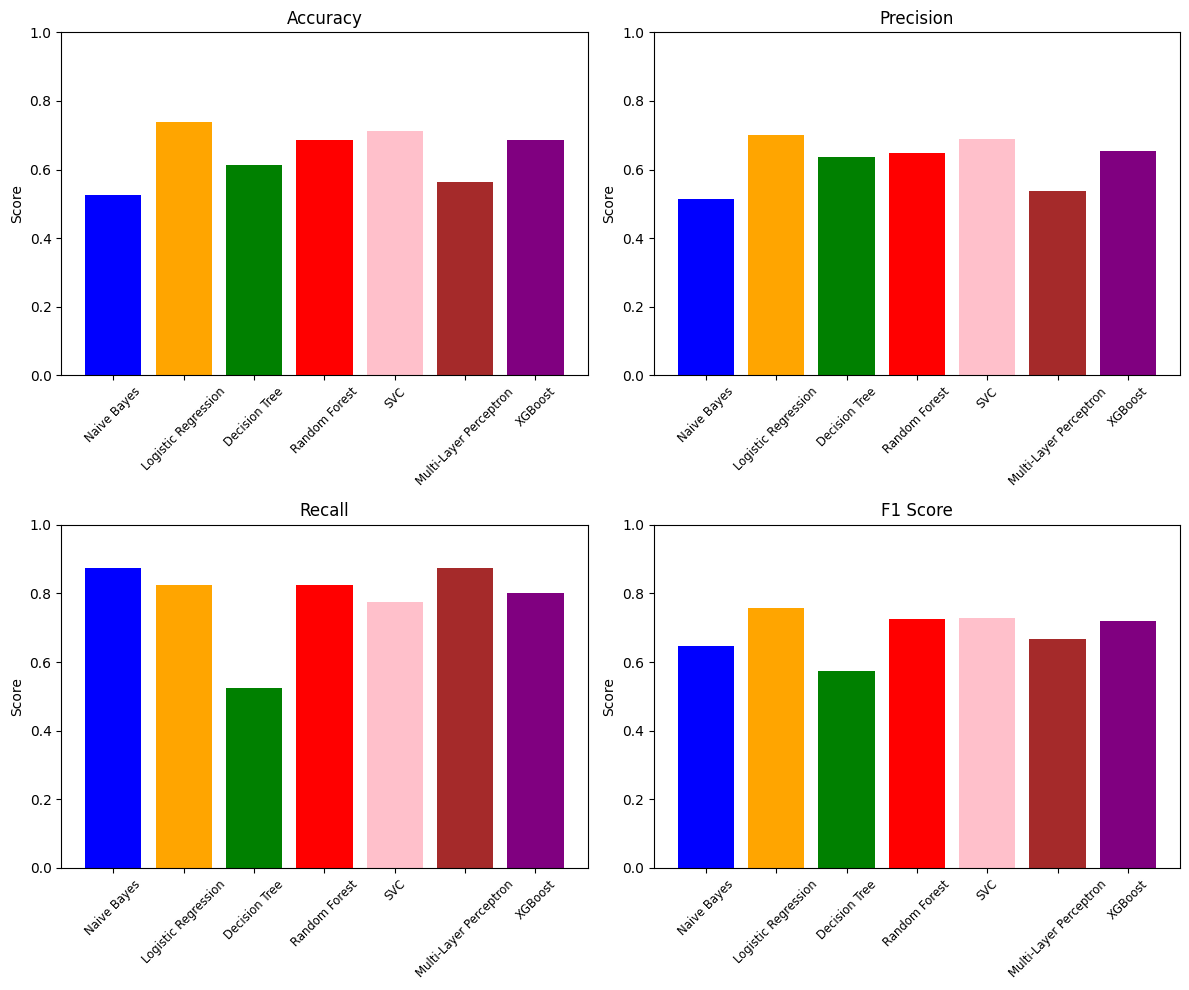

Classifier: Naive Bayes
Accuracy: 0.53
Precision: 0.51
Recall: 0.88
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.74
Precision: 0.70
Recall: 0.82
F1 Score: 0.76
------------------------------
Classifier: Decision Tree
Accuracy: 0.61
Precision: 0.64
Recall: 0.53
F1 Score: 0.58
------------------------------
Classifier: Random Forest
Accuracy: 0.69
Precision: 0.65
Recall: 0.82
F1 Score: 0.73
------------------------------
Classifier: SVC
Accuracy: 0.71
Precision: 0.69
Recall: 0.78
F1 Score: 0.73
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.56
Precision: 0.54
Recall: 0.88
F1 Score: 0.67
------------------------------
Classifier: XGBoost
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------


In [31]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)

## VADER Sentiment

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

Use full_article field, which is a compoination of the 3 article fields without applying preprocessing techniques.

In [33]:
vader_pred = []
for article in dataset["full_article"]:
    vader_pred.append(1 if analyzer.polarity_scores(article)['compound'] > 0 else 0)

In [34]:
print("Accuracy: ", accuracy_score(y, vader_pred))
print("Precision: ", precision_score(y, vader_pred))
print("Recall: ", recall_score(y, vader_pred))
print("F1: ", f1_score(y, vader_pred))

Accuracy:  0.595
Precision:  0.572972972972973
Recall:  0.9814814814814815
F1:  0.7235494880546075


## Afinn Sentiment

In [35]:
from afinn import Afinn

afn = Afinn()

In [36]:
scores = [afn.score(article) for article in dataset["full_article"]]
sentiment = [
    "positive" if score >= 0 else "negative"
    for score in scores
]

afinn_pred = []
for article in dataset["full_article"]:
    afinn_pred.append(1 if afn.score(article) > 0 else 0)

In [37]:
print("Accuracy: ", accuracy_score(y, afinn_pred))
print("Precision: ", precision_score(y, afinn_pred))
print("Recall: ", recall_score(y, afinn_pred))
print("F1: ", f1_score(y, afinn_pred))

Accuracy:  0.6025
Precision:  0.5785123966942148
Recall:  0.9722222222222222
F1:  0.7253886010362695


## SentiWordNet

In [68]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

# nltk.download("sentiwordnet")
# nltk.download("wordnet")
# nltk.download("averaged_perceptron_tagger")

sentiwordnet_pred = []
for article in dataset["full_article"]:
    tokenSentence = nltk.word_tokenize(article)
    posTagSentence = nltk.pos_tag(tokenSentence)

    sentimentPositive = 0.0
    sentimentNegative = 0.0
    articleCount = 0
    final_sentiment = 0

    for wordTagPair in posTagSentence:

        word = wordTagPair[0]
        posTag = wordTagPair[1]

        if posTag.startswith("J"):
            posTag = wn.ADJ
        elif posTag.startswith("R"):
            posTag = wn.ADV
        elif posTag.startswith("N"):
            posTag = wn.NOUN
        else:
            continue

        wordSynst = wn.synsets(word, pos=posTag)
        if not wordSynst:
            continue
        chosenSynst = wordSynst[0]
        sentiWordNet = swn.senti_synset(chosenSynst.name())
        sentimentPositive += sentiWordNet.pos_score()
        sentimentNegative += sentiWordNet.neg_score()
        articleCount += 1

    if sentimentPositive > sentimentNegative:
        final_sentiment = 1
    else:
        final_sentiment = 0


    sentiwordnet_pred.append(final_sentiment)

In [69]:
print("Accuracy: ", accuracy_score(y, sentiwordnet_pred))
print("Precision: ", precision_score(y, sentiwordnet_pred))
print("Recall: ", recall_score(y, sentiwordnet_pred))
print("F1: ", f1_score(y, sentiwordnet_pred))

Accuracy:  0.625
Precision:  0.6447368421052632
Recall:  0.6805555555555556
F1:  0.6621621621621622


As we can see, SentiWordNet was the best in classifying sentiment, lets use it to add labels to the dataset, and re-apply our classifier

In [70]:
dataset["sentiwordnet_pred"] = sentiwordnet_pred
dataset

,Date_published,Headline,Synopsis,Full_text,Final Status,processed_article,full_article,sentiwordnet_pred
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,0,bank hold on to subsidi share say payment firm...,"Banks holding on to subsidy share, say payment...",0
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,1,digit readi bank of baroda aim to click on mor...,Digitally ready Bank of Baroda aims to click o...,1
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1,karnataka attract invest commit of rs crore at...,Karnataka attracted investment commitment of R...,1
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,0,split of provid fund account may be delay the ...,Splitting of provident fund accounts may be de...,1
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,1,irdai weigh propos to privatis insur inform bu...,Irdai weighs proposal to privatise Insurance I...,1
...,...,...,...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",0,bank take a cue from rbi hike lend rate these ...,"Banks take a cue from RBI, hike lending rates ...",1
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,0,sebi issu rs lakh recoveri notic to individu i...,Sebi issues Rs 27 lakh recovery notice to indi...,0
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,0,apollo hospit share drop as sensex fall a tota...,Apollo Hospital shares drop 0.68% as Sensex ...,1
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,1,sbi at rs what make analyst see up to upsid in...,SBI at Rs 710? What makes analysts see up to 5...,1


In [72]:
sentiword_preds = np.array(dataset["sentiwordnet_pred"]).reshape(-1, 1)
sentiword_preds

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [73]:
X2 = X.copy()
X2 = np.hstack((X2, sentiword_preds))
X2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y, test_size=0.2, random_state=42
)

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

print("\nLabel distribution in the training set:")
print(y_train2.value_counts())

print("\nLabel distribution in the test set:")
print(y_test2.value_counts())

(320, 58852) (320,)
(80, 58852) (80,)

Label distribution in the training set:
Final Status
1    176
0    144
Name: count, dtype: int64

Label distribution in the test set:
Final Status
0    40
1    40
Name: count, dtype: int64


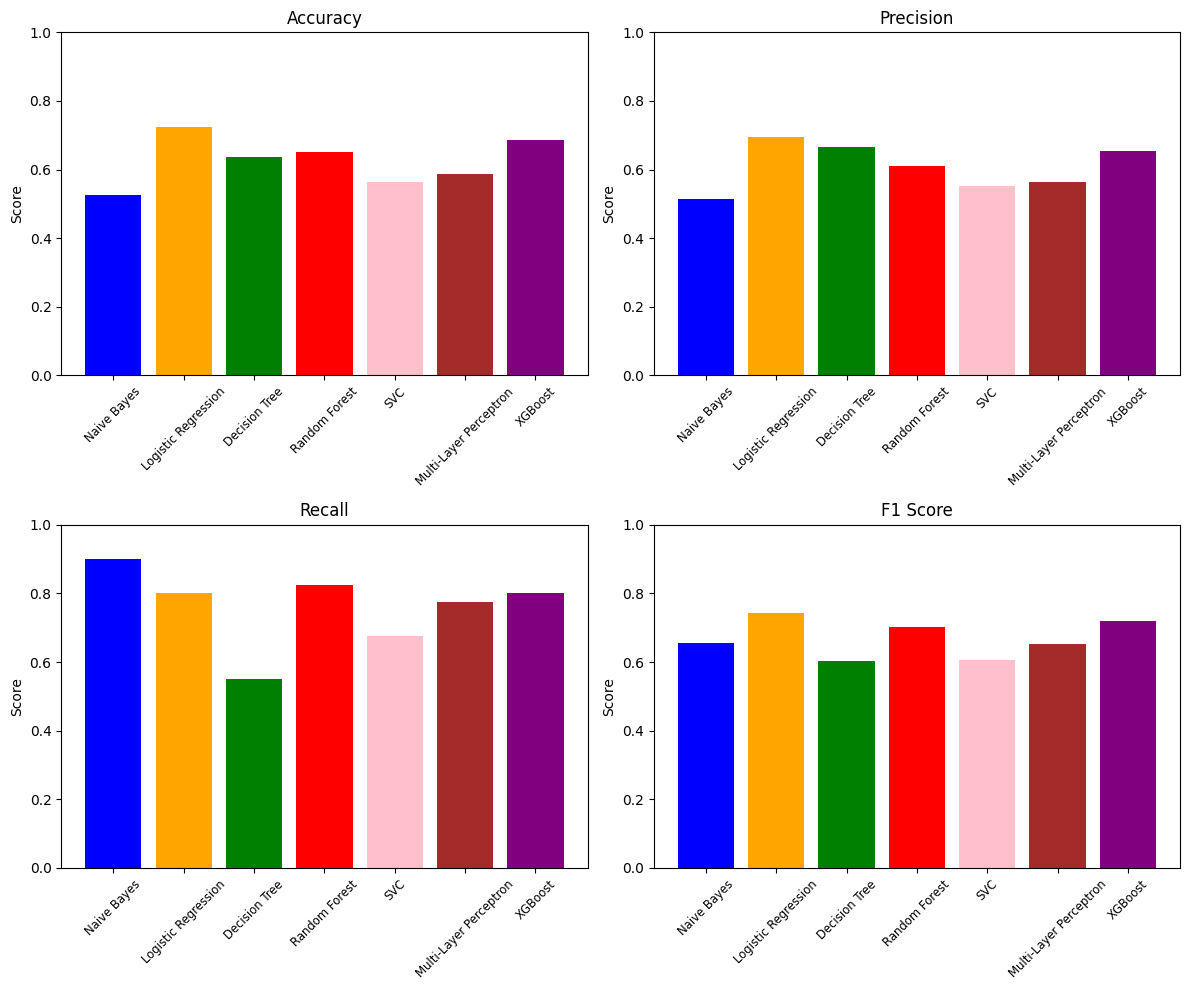

Classifier: Naive Bayes
Accuracy: 0.53
Precision: 0.51
Recall: 0.90
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.72
Precision: 0.70
Recall: 0.80
F1 Score: 0.74
------------------------------
Classifier: Decision Tree
Accuracy: 0.64
Precision: 0.67
Recall: 0.55
F1 Score: 0.60
------------------------------
Classifier: Random Forest
Accuracy: 0.65
Precision: 0.61
Recall: 0.82
F1 Score: 0.70
------------------------------
Classifier: SVC
Accuracy: 0.56
Precision: 0.55
Recall: 0.68
F1 Score: 0.61
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.59
Precision: 0.56
Recall: 0.78
F1 Score: 0.65
------------------------------
Classifier: XGBoost
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------


In [75]:
evaluations2 = {
    classifier_name: evaluate_classifier(classifier, X_train2, y_train2, X_test2, y_test2)
    for classifier_name, classifier in classifiers_tuned.items()
}
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

colors = ["blue", "orange", "green", "red", "pink", "brown", "purple"]

for i, metric in enumerate(metrics_names):
    row = i // 2
    col = i % 2
    scores = [evaluation[i] for evaluation in evaluations2.values()]
    axs[row, col].bar(classifiers.keys(), scores, color=colors)
    axs[row, col].set_title(metric)
    axs[row, col].set_ylabel("Score")
    axs[row, col].set_ylim([0, 1])
    axs[row, col].tick_params(axis="x", labelrotation=45, labelsize="small")

plt.tight_layout()
plt.show()

for classifier_name, metrics in evaluations2.items():
    print(f"Classifier: {classifier_name}")
    print(f"Accuracy: {metrics[0]:.2f}")
    print(f"Precision: {metrics[1]:.2f}")
    print(f"Recall: {metrics[2]:.2f}")
    print(f"F1 Score: {metrics[3]:.2f}")
    print("-" * 30)


From classifiers without lexicon sentiment analysis:

```md
Classifier: Naive Bayes
Accuracy: 0.53
Precision: 0.51
Recall: 0.88
F1 Score: 0.65
------------------------------
Classifier: Logistic Regression
Accuracy: 0.74
Precision: 0.70
Recall: 0.82
F1 Score: 0.76
------------------------------
Classifier: Decision Tree
Accuracy: 0.61
Precision: 0.64
Recall: 0.53
F1 Score: 0.58
------------------------------
Classifier: Random Forest
Accuracy: 0.69
Precision: 0.65
Recall: 0.82
F1 Score: 0.73
------------------------------
Classifier: SVC
Accuracy: 0.71
Precision: 0.69
Recall: 0.78
F1 Score: 0.73
------------------------------
Classifier: Multi-Layer Perceptron
Accuracy: 0.56
Precision: 0.54
Recall: 0.88
F1 Score: 0.67
------------------------------
Classifier: XGBoost
Accuracy: 0.69
Precision: 0.65
Recall: 0.80
F1 Score: 0.72
------------------------------
```

As we can see, sicne the sentiwordnet was not perfect, it didn´t improve the classification